In [1]:
%matplotlib inline 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
import numpy as np
import time
import matplotlib.pyplot as plt
from depthwise_conv2d import DepthwiseConv2D
import tensorflow as tf


def get_conv(filter_num, param):
    return param["conv"](filter_num, param["kernel_size"], padding='same', use_bias=False)

image_size = 32
batch_num = 32
layer_num = 16
filter_nums = [8, 16, 32, 64]
device_mode = "/gpu:0"
# device_mode = "/cpu:0"

params = {
    "conv5x5": {"kernel_size": (5, 5), "conv": Conv2D},
    "conv3x3": {"kernel_size": (3, 3), "conv": Conv2D},
    "conv3x3sep": {"kernel_size": (3, 3), "conv": DepthwiseConv2D},
    "conv1x1": {"kernel_size": (1, 1), "conv": Conv2D},
    "conv1x3": {"kernel_size": (1, 3), "conv": Conv2D},
    "conv3x1": {"kernel_size": (3, 1), "conv": Conv2D}
}

results = {}

for name, param in params.items():
    timings = []

    for filter_num in filter_nums:
        with tf.device(device_mode):
            layers = [get_conv(filter_num, param) for _ in range(layer_num)]
            input_shape = (image_size, image_size, filter_num)
            model = Sequential()
            model.add(param["conv"](filter_num, param["kernel_size"], padding='same',
                                          input_shape=input_shape, use_bias=False))
            
            for _ in range(layer_num - 1):
                model.add(get_conv(filter_num, param))
            
            input = np.random.randn(batch_num, image_size, image_size, filter_num)
            out = model.predict(input, batch_size=batch_num)
    
            start = time.time()
    
            for i in range(100):
                out = model.predict(input, batch_size=batch_num)
    
            elapsed_time = time.time() - start
            timings.append(elapsed_time)

    results[name] = timings

Using TensorFlow backend.


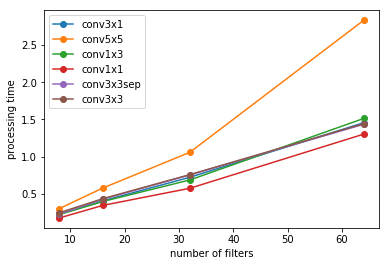

In [2]:
for name in params.keys():
    plt.plot(filter_nums, results[name], label=name, marker="o")

plt.xlabel("number of filters")
plt.ylabel("processing time")
plt.legend()

In [3]:
convs = ["conv1x1", "conv3x1", "conv1x3", "conv3x3sep", "conv3x3", "conv5x5"]

print("||" + "|".join(convs) + "|")
print("|:-:|:-:|:-:|:-:|:-:|:-:|:-:|")
print("|processing time [sec]|" + "|".join(["{:0.3f}".format(results[n][-1]) for n in convs]) + "|")
print("|vs 3x3|" + "|".join(["{:0.3f}".format(results[n][-1]/results["conv3x3"][-1]) for n in convs]) + "|")
print("|theoretical complexity|0.111|0.333|0.333|0.016|1.000|2.778|")

||conv1x1|conv3x1|conv1x3|conv3x3sep|conv3x3|conv5x5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|processing time [sec]|1.303|1.457|1.514|1.436|1.443|2.835|
|vs 3x3|0.903|1.009|1.049|0.995|1.000|1.965|
|theoretical complexity|0.111|0.333|0.333|0.016|1.000|2.778|
